In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyhacores.utils import *
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

# Applications

## Real filter

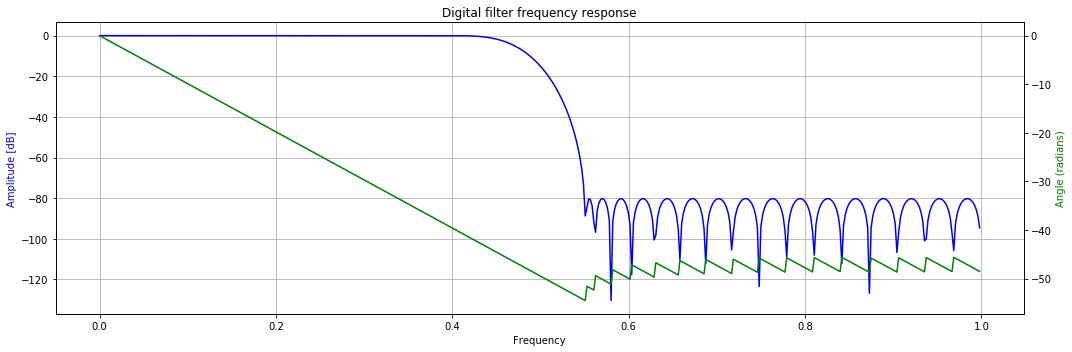

In [3]:
taps = scipy.signal.remez(64, [0, 0.4/2, 0.55/2, 1.0/2], [1, 0])
show_freqz(taps)

### Frequency response

In [4]:
# NBVAL_IGNORE_OUTPUT
input_signal = [0.0] * 512
input_signal[0] = 1.0

from pyhacores.filter import FIR
dut = FIR(taps, dtype=Sfix)
sims = simulate(dut, input_signal, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 514/514 [00:00<00:00, 1603.74it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


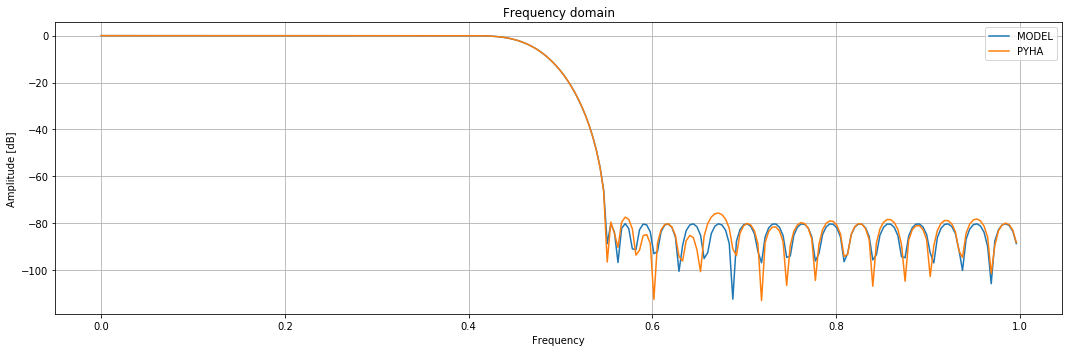

In [5]:
plt.title('Frequency domain')
gain_fix = len(input_signal)
for key, value in sims.items():
    plt.magnitude_spectrum(np.array(value) * gain_fix, window=plt.mlab.window_none, scale='dB', label=key)

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
show_plot()

## Complex filter

### Frequency response

In [6]:
# NBVAL_IGNORE_OUTPUT
input_signal = [0.0 + 0.0j] * 512
input_signal[0] = 1.0 + 1.0j

dut = FIR(taps, dtype=Complex)
sims = simulate(dut, input_signal, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 514/514 [00:00<00:00, 1665.01it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


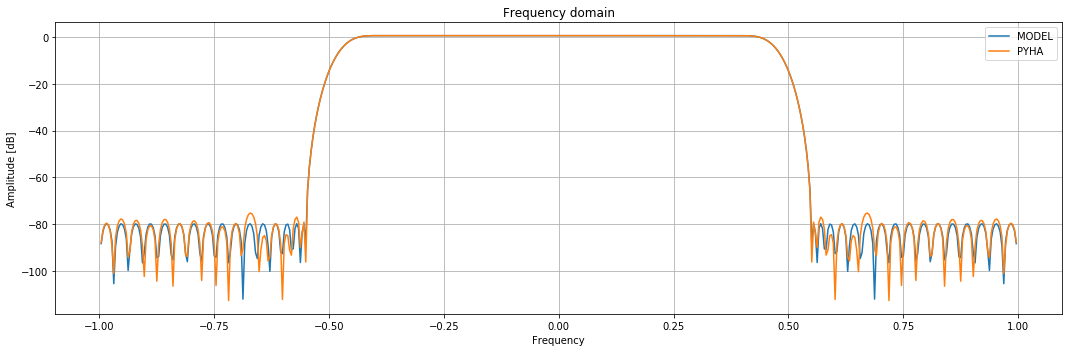

In [7]:
plt.title('Frequency domain')
gain_fix = len(input_signal) - 128
for key, value in sims.items():
    plt.magnitude_spectrum(np.array(value) * gain_fix, window=plt.mlab.window_none, scale='dB', label=key)

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
show_plot()

### Filtering

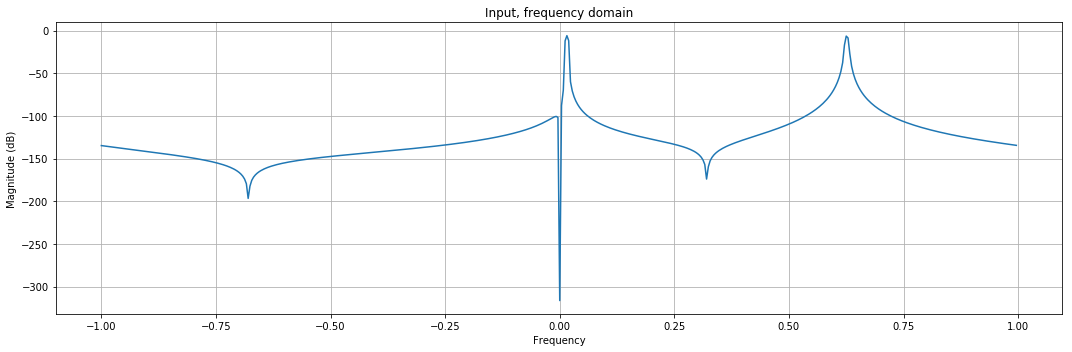

In [8]:
fs = 256
t = np.linspace(0, 2, 2*fs)
s0 = np.exp(2 * np.pi * 2 * t * 1j) * 0.5
s1 = np.exp(2 * np.pi * 80 * t * 1j) * 0.5
input_signal = s0 + s1

plt.title('Input, frequency domain')
plt.magnitude_spectrum(input_signal, scale='dB')
show_plot()

In [9]:
dut = FIR(taps, dtype=Complex)
sims = simulate(dut, input_signal, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 514/514 [00:00<00:00, 1545.45it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


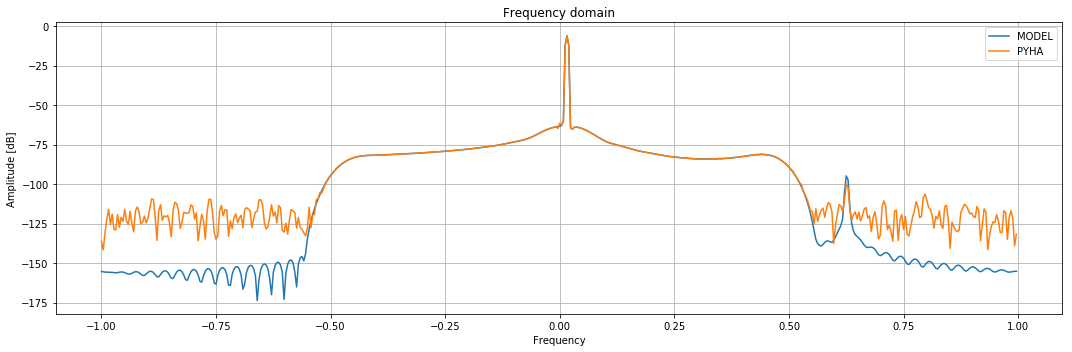

In [10]:
plt.title('Frequency domain')
for key, value in sims.items():
    plt.magnitude_spectrum(value, scale='dB', label=key)

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
show_plot()

## Complex Half-band filter
Half-band filters have half of the coefficents zero, saves multipliers.
See: https://www.dsprelated.com/showcode/270.php

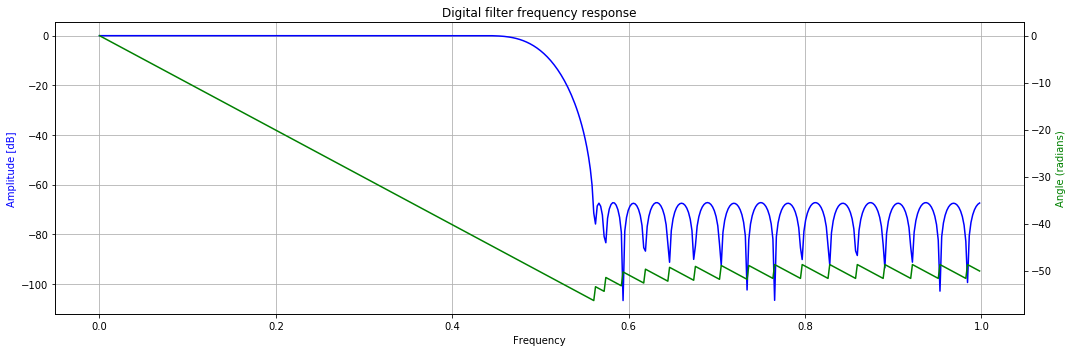

In [11]:
N = 64  # Filter order
bands = np.array([0., .22, .28, .5]) # Filter symetric around 0.25 (where .5 is pi or Fs/2)
halfband_taps =  signal.remez(N+1, bands, [1,0], [1,1])
halfband_taps[abs(halfband_taps) <= 1e-4] = 0.
show_freqz(halfband_taps)

### Filtering

In [12]:
dut = FIR(halfband_taps, dtype=Complex)
sims = simulate(dut, input_signal, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 514/514 [00:00<00:00, 1499.22it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


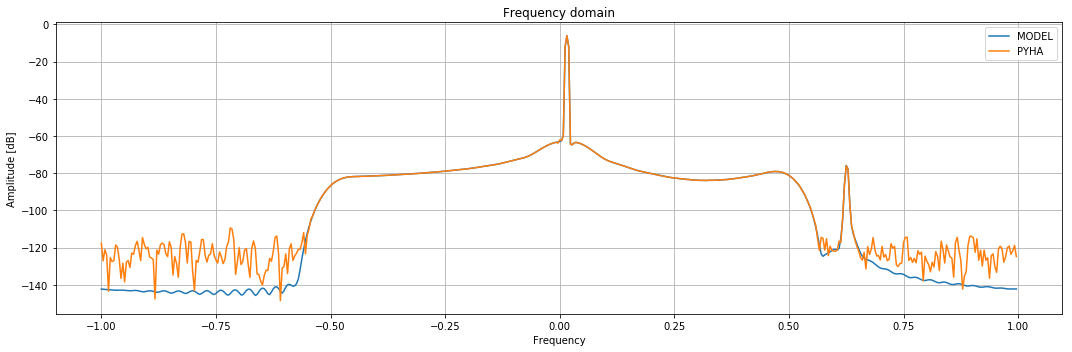

In [13]:
plt.title('Frequency domain')
for key, value in sims.items():
    plt.magnitude_spectrum(value, scale='dB', label=key)

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
show_plot()

# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [14]:
print(f'Minimum number representabe: {2**-17}')

Minimum number representabe: 7.62939453125e-06


## Possible overflow inside the FIR core
Maximum accumulation value in the core depends on the filter coefficents and input magnitude. Core has 1 bit to protect the accumulator, but the output is still resized to the standard type (-1 .. 1 range). Overflow on output is protected by saturation, which is a bit better compared to wrap.

In [15]:
taps = halfband_taps
print(f'Maximum output value of the filter (assuming worst case input): {np.sum(np.abs(taps))}')

Maximum output value of the filter (assuming worst case input): 1.7492461879656656


In [16]:
np.random.seed(0)  # reproduce tests
inp = np.random.uniform(-1, 1, 512) + np.random.uniform(-1, 1, 512)*1j
# inp *= 0.8 # uncomment to avoid overflows

In [17]:
dut = FIR(taps, dtype=Complex)
sims = simulate(dut, inp, simulations=simulations)
assert hardware_sims_equal(sims)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 514/514 [00:00<00:00, 1521.69it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:Testing hardware simulations equality...
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!


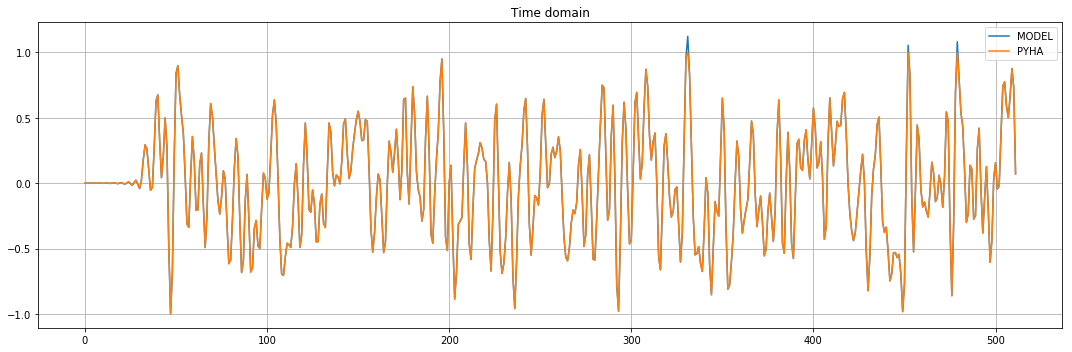

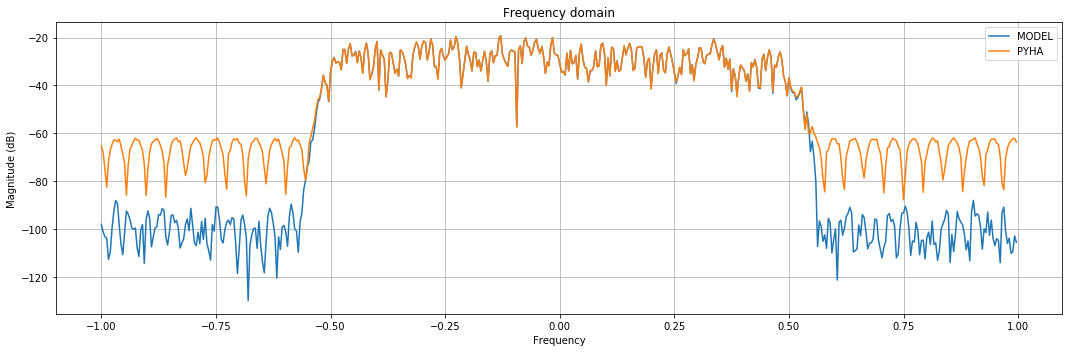

In [18]:
plt.title('Time domain')
for key, value in sims.items():
    plt.plot(value, label=key)
show_plot()

plt.title('Frequency domain')
for key, value in sims.items():
    plt.magnitude_spectrum(value, scale='dB', label=key)
show_plot()

## Maximum stopband rejection is about 80db
This due to 18bit taps. Below is an example that tries to use filter with better stopband.

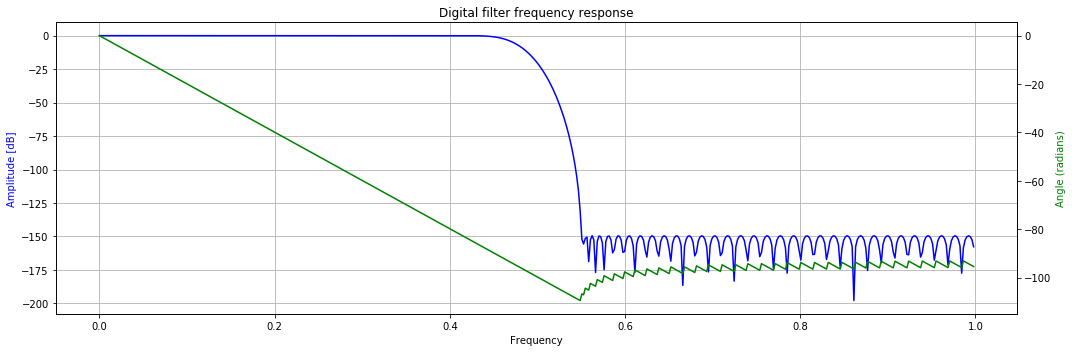

In [19]:
taps = scipy.signal.remez(128, [0, 0.4/2, 0.55/2, 1.0/2], [1, 0])
show_freqz(taps)

In [20]:
# NBVAL_IGNORE_OUTPUT
input_signal = [0.0 + 0.0j] * 512
input_signal[0] = 1.0 + 1.0j

dut = FIR(taps, dtype=Complex)
sims = simulate(dut, input_signal, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 514/514 [00:00<00:00, 834.28it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


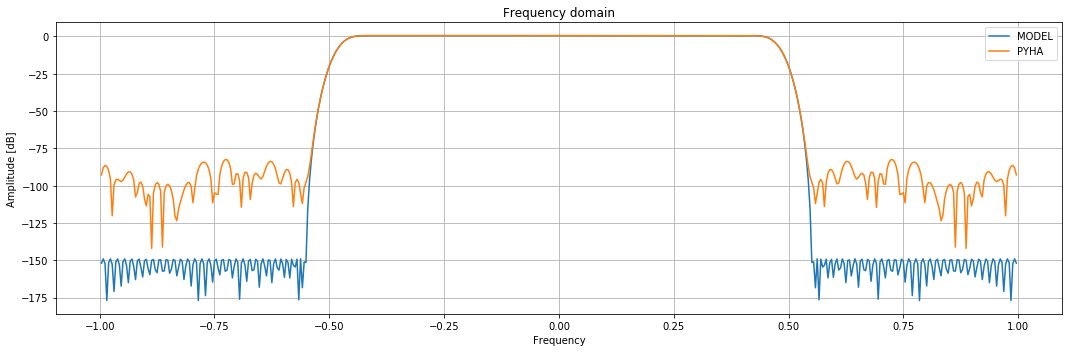

In [21]:
plt.title('Frequency domain')
gain_fix = len(input_signal) - 128
for key, value in sims.items():
    plt.magnitude_spectrum(np.array(value) * gain_fix, window=plt.mlab.window_none, scale='dB', label=key)

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
show_plot()

# Synthesis
Resource usage depends heavily on filter taps. For example, 64 tap halfband filter needs only 16 multipliers (18bit). Complex signal needs 2 filters, so in total we could expect 32 multipliers (18bit).

In [22]:
# NBVAL_IGNORE_OUTPUT
output_dir = '/tmp/pyha_output'
sims = simulate(dut, input_signal, simulations=['PYHA', 'GATE'], conversion_path=output_dir)

INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 514/514 [00:02<00:00, 223.91it/s]

INFO:sim:OK!
INFO:sim:Running "GATE" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:FIR to VHDL ...


INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Wed Aug  1 16:27:15 2018
INFO:sim:Quartus Prime Version : 17.1.0 Build 590 10/25/2017 SJ Lite Edition
INFO:sim:Revision Name : quartus_project
INFO:sim:Top-level Entity Name : top
INFO:sim:Family : Cyclone IV E
INFO:sim:Total logic elements : 4,320
INFO:sim:    Total combinational functions : 4,126
INFO:sim:    Dedicated logic registers : 4,163
INFO:sim:Total registers : 4163
INFO:sim:Total pins : 74
INFO:sim:Total virtual pins : 0
INFO:sim:Total memory bits : 228
INFO:sim:Embedded Multiplier 9-bit elements : 164
INFO:sim:Total PLLs : 0
INFO:sim:Running netlist writer.
INFO:sim:Running COCOTB & GHDL simulation....
ERROR:sim:Build with GHDL/Cocotb failed:
    /tmp/pyha_output/quartus/simulation/modelsim/quartus_project.vho: In function ‘work__top__ARCH__structure__STMT_ELAB’:
    /tmp/pyha_output/quartus/simulation/modelsim/quartus_project.vho:162088:0: internal compiler error: Segmentatio

Exception: Build with GHDL/Cocotb failed:
    /tmp/pyha_output/quartus/simulation/modelsim/quartus_project.vho: In function ‘work__top__ARCH__structure__STMT_ELAB’:
    /tmp/pyha_output/quartus/simulation/modelsim/quartus_project.vho:162088:0: internal compiler error: Segmentation fault
     ww_out0(35) <= \out0[35]~output_o\;
     
    Please submit a full bug report,
    with preprocessed source if appropriate.
    See <https://gcc.gnu.org/bugs/> for instructions.
    /usr/bin/ghdl: exec error
    make[1]: *** [/home/gaspar/git/pyha/cocotb/makefiles/simulators/Makefile.ghdl:60: analyse] Error 3
    make: *** [/home/gaspar/git/pyha/pyha/../cocotb/makefiles/Makefile.sim:72: sim] Error 2

In [ ]:
assert hardware_sims_equal(sims)

In [ ]:
from pyha.simulation.vhdl_simulation import VHDLSimulation
print(f'Logic elements: {VHDLSimulation.last_logic_elements}')
print(f'Memory: {VHDLSimulation.last_memory_bits}')
print(f'Multipler (18bit): {VHDLSimulation.last_multiplier//2}')